# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score

# Metrics
from sklearn.metrics import (roc_curve, roc_auc_score, classification_report, confusion_matrix,
                             precision_recall_curve, auc, accuracy_score, f1_score)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Load Data

In [3]:
from sklearn.datasets import make_blobs
import pandas as pd
X, _ = make_blobs(n_samples=200, centers=3, n_features=2, cluster_std =0.5, random_state=0)
df = pd.DataFrame(X, columns = ["feature1", "feature2"])
df.head(5)

,feature1,feature2
0,-1.630356,3.357972
1,0.802314,4.381962
2,1.053744,4.492869
3,-1.478042,3.209359
4,1.125389,4.966980


# Visualize Data

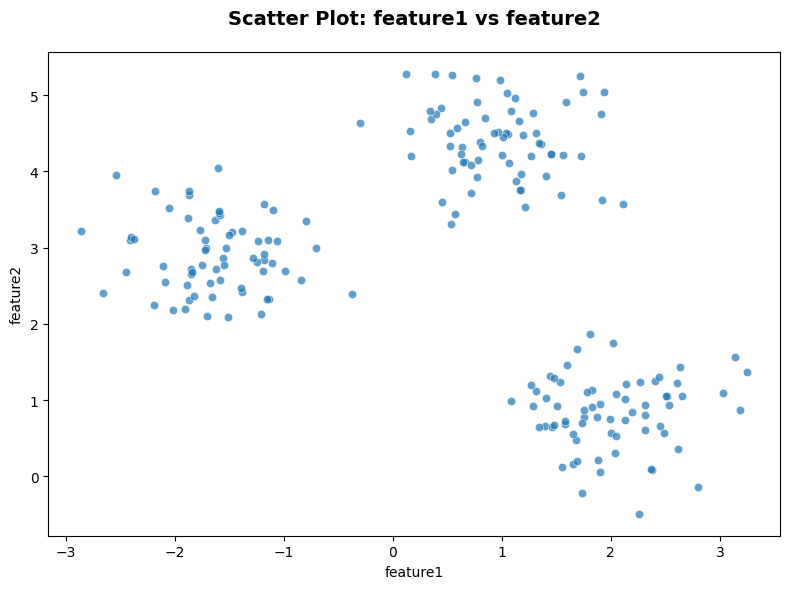

In [4]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x="feature1",
    y="feature2",
    alpha=0.7
)
plt.title("Scatter Plot: feature1 vs feature2", pad = 20, weight = "bold", fontsize=14)
plt.xlabel("feature1")
plt.ylabel("feature2")
plt.tight_layout()
plt.show()


# Overview Data

In [5]:
display(df.head(5))
display(df.tail(5))

,feature1,feature2
0,-1.630356,3.357972
1,0.802314,4.381962
2,1.053744,4.492869
3,-1.478042,3.209359
4,1.125389,4.966980


,feature1,feature2
195,2.618585,0.357698
196,-1.868909,3.747658
197,2.510357,1.056273
198,1.132804,3.876739
199,1.692469,0.205982


## Show Info

In [12]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature1  200 non-null    float64
 1   feature2  200 non-null    float64
dtypes: float64(2)
memory usage: 3.3 KB


None

## Describe Data

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
feature1,200.0,0.460151,1.606159,-2.856490,-1.213346,0.990335,1.725847,3.246840
feature2,200.0,2.707674,1.545307,-0.488633,1.133143,2.848963,4.107777,5.279175


## Check Duplicate

In [13]:
#TODO2: Check Duplicate
print('Check Duplicate Value: ',df.duplicated().sum())

Check Duplicate Value:  0


* dataset trên không có dữ liệu bị duplicate -> không cần xử lý

## Check Null

In [14]:
df.isnull().sum()

,0
feature1,0
feature2,0


## Encoding

In [ ]:
#Data k có dữ liệu dạng category mình chưa cần bước này

## Scale Data

In [7]:
from sklearn.preprocessing import StandardScaler
features_to_scale = ['feature1', 'feature2']
df_to_scale = df[features_to_scale]
scaler = StandardScaler()
df_scaled_standard = pd.DataFrame(scaler.fit_transform(df_to_scale), columns=features_to_scale)
df_scaled_standard

,feature1,feature2
0,-1.304823,0.421877
1,0.213567,1.086184
2,0.370501,1.158135
3,-1.209753,0.325465
4,0.415219,1.465712
...,...,...
195,1.347221,-1.524534
196,-1.453720,0.674683
197,1.279669,-1.071338
198,0.419847,0.758424


In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
model = KMeans(n_clusters=3, random_state=0)
model.fit(df_scaled_standard)
print(len(model.labels_))
print("Error", model.inertia_)
s_score = silhouette_score(df_scaled_standard, model.labels_)
print("silhouette_score", s_score)

#TODO: for k trong danh sách từ 1-12
# với mỗi k -> fit model kmeans, append error và s_score vào list_error, ls_s_score
# visualize 2 chart: Chart Elbow Method (ox=list_k, oy=ls_error) và Chart Sihouette Method (ox=list_k, oy=ls_s_score)
#TODO: mn làm trong 4p

200
Error 38.05406829425629
silhouette_score 0.7286250137293263


In [9]:
!pip install kneed

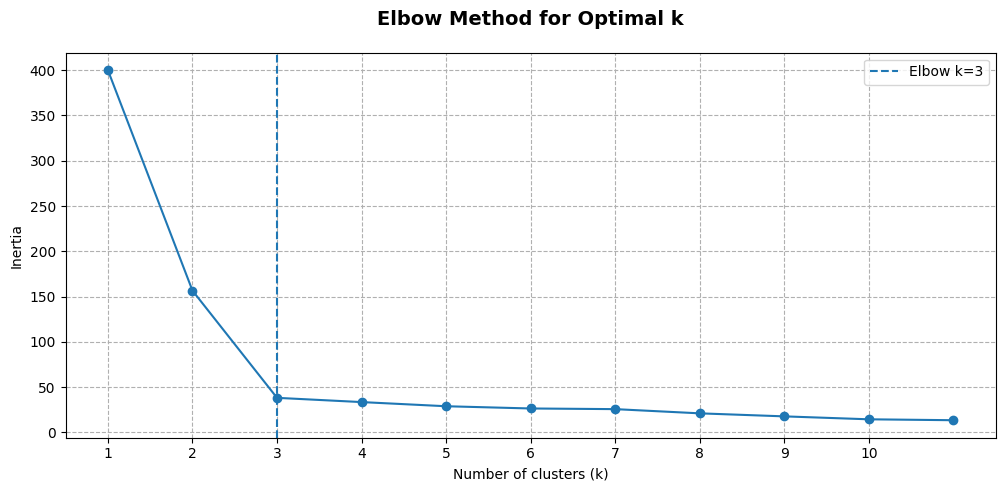

Optimal k suggested by Elbow: 3


In [10]:
from kneed import KneeLocator # Refer on Kaggle

# --- Elbow Method ---
inertia = []
K_elbow = range(1, 12)  # k = 1..12
for k in K_elbow:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(df_scaled_standard)
    inertia.append(kmeans.inertia_)

# Find the elbow point
kneedle = KneeLocator(list(K_elbow), inertia, curve="convex", direction="decreasing")
k_best_elbow = kneedle.knee

# Plot Elbow
plt.figure(figsize=(12, 5))
plt.plot(list(K_elbow), inertia, marker="o", linestyle="-")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k", fontsize=14, pad=20, weight="bold")
plt.grid(True, linestyle="--")
plt.xticks(range(1, 11))

# Mark elbow if found
if k_best_elbow is not None:
    plt.axvline(k_best_elbow, linestyle="--", label=f"Elbow k={k_best_elbow}")
    plt.legend()

plt.show()

print(f"Optimal k suggested by Elbow: {k_best_elbow}")

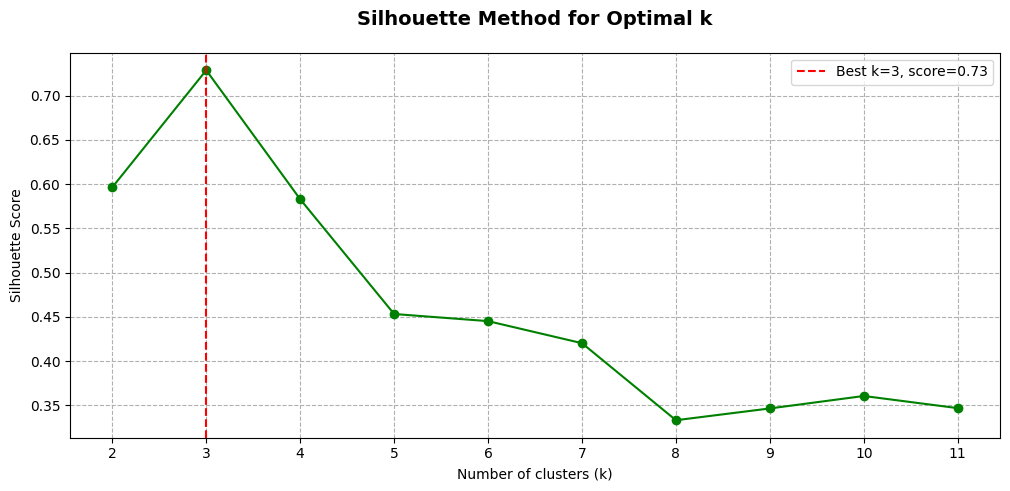

Optimal k suggested by Silhouette: 3


In [11]:
# --- Silhouette Method ---
silhouette_scores = []
K_silhouette = range(2, 12)  # silhouette score không dùng được với k=1

for k in K_silhouette:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(df_scaled_standard)
    score = silhouette_score(df_scaled_standard, labels)
    silhouette_scores.append(score)

# Tìm k có silhouette score cao nhất
best_k_silhouette = K_silhouette[silhouette_scores.index(max(silhouette_scores))]

# Plot Silhouette
plt.figure(figsize=(12, 5))
plt.plot(list(K_silhouette), silhouette_scores, marker="o", linestyle="-", color="green")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method for Optimal k", fontsize=14, pad=20, weight="bold")
plt.grid(True, linestyle="--")
plt.xticks(range(2, 12))

# Mark best silhouette score
plt.axvline(best_k_silhouette, linestyle="--", color="red",
            label=f"Best k={best_k_silhouette}, score={max(silhouette_scores):.2f}")
plt.legend()

plt.show()

print(f"Optimal k suggested by Silhouette: {best_k_silhouette}")


# CHỌN K = 3

In [15]:
best_k = 3
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
kmeans.fit(df_scaled_standard)
df["name_cluster"] = kmeans.labels_
df["name_cluster"]

,name_cluster
0,2
1,0
2,0
3,2
4,0
...,...
195,1
196,2
197,1
198,0


# CLUSTER ANALYSIS

## HOMEWORK

### Visualize Scatter Plot
* Thêm thông tin về cluster_name, cluster_centers

Visualize Or Table kết hợp với tìm đặc điểm của từng feature trên từng nhóm sau đó rút ra kết luận

* Nhóm 1: có đặc điểm gì
* Nhóm 2: có đặc điểm gì
* Nhóm 3: có đặc điểm gì

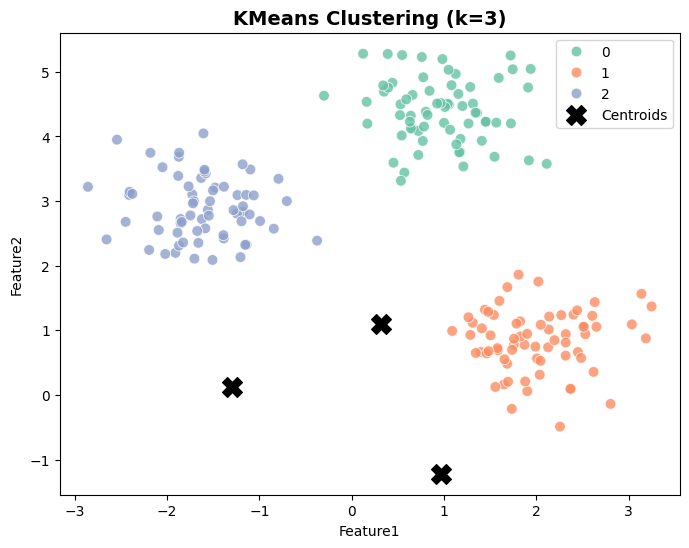

In [17]:
# Scatter plot 2 feature
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x="feature1",
    y="feature2",
    hue="name_cluster",
    palette="Set2",
    s=60,
    alpha=0.8
)

# Vẽ centroid (tâm cụm)
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0], centroids[:, 1],
    s=200, c="black", marker="X", label="Centroids"
)

plt.title("KMeans Clustering (k=3)", fontsize=14, weight="bold")
plt.xlabel("Feature1")
plt.ylabel("Feature2")
plt.legend()
plt.show()


**Phân tích từng cụm**

* **Cluster 0 (màu xanh nhạt, bên trên)**
* **Cluster 1 (màu cam, bên phải dưới)**
* **Cluster 2 (màu tím, bên trái giữa)**

**Nhóm 1 (Cluster 0 - màu xanh nhạt, phía trên)**

* **Feature1:** quanh giá trị dương vừa phải (0 → 2).
* **Feature2:** cao, từ 3 đến 5.
* Đây là nhóm có **Feature2 cao nhất** trong 3 nhóm, trong khi Feature1 ở mức trung bình.
* **Đặc điểm:** đại diện cho tập đối tượng “Feature2 mạnh/điểm cao”, Feature1 trung bình.

**Nhóm 2 (Cluster 1 - màu cam, phía dưới bên phải)**

* **Feature1:** chủ yếu từ 1 đến 3.
* **Feature2:** thấp, tập trung 0 → 2.
* Đây là nhóm có **Feature1 cao** nhưng **Feature2 thấp**.
* **Đặc điểm:** đại diện cho tập đối tượng thiên về Feature1, nhưng hạn chế ở Feature2.

**Nhóm 3 (Cluster 2 - màu tím, bên trái giữa)**

* **Feature1:** âm (-3 → -1).
* **Feature2:** trung bình, khoảng 2 → 4.
* Đây là nhóm có **Feature1 thấp (âm)**, nhưng Feature2 khá ổn định ở mức trung bình.
* **Đặc điểm:** đối tượng có xu hướng kém ở Feature1 nhưng cân bằng ở Feature2.

**Bảng tóm tắt đặc điểm (giá trị trung bình)**

| Cluster            | Feature1 (xu hướng) | Feature2 (xu hướng) | Đặc điểm nổi bật                 |
| ------------------ | ------------------- | ------------------- | -------------------------------- |
| 0 (nhóm xanh trên) | Trung bình (0 → 2)  | **Cao (3 → 5)**     | Feature2 nổi trội                |
| 1 (nhóm cam phải)  | **Cao (1 → 3)**     | Thấp (0 → 2)        | Feature1 nổi trội                |
| 2 (nhóm tím trái)  | **Thấp (-3 → -1)**  | Trung bình (2 → 4)  | Feature1 thấp, Feature2 cân bằng |

**Kết luận**

* **Nhóm 1:** mạnh về **Feature2**, thích hợp mô tả nhóm có “chỉ số thứ 2” vượt trội.
* **Nhóm 2:** nổi bật về **Feature1**, nhưng hạn chế ở Feature2.
* **Nhóm 3:** kém ở **Feature1**, nhưng có Feature2 mức trung bình khá.